# Einstein Bianchi linearized equations


In [3]:
# neccessary imports
from ngsolve import *
from zenith import *
from ngsolve.webgui import Draw

ImportError: cannot import name 'solve' from 'ngsolve' (c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\ngsolve\ngslib.pyd)

In [202]:
# create  a black hole at the origin
mass = 1
bh = BlackHole(mass=mass)

bh_list = [bh]
mesh = DefaultMesh(bh_list=bh_list, adaption=True, h=0.2, R=3)

{'bh_list': [<zenith.utils.CompactObjects.BlackHole object at 0x0000018998476AD0>], 'adaption': True}


In [203]:
#Draw(mesh, clipping='z')

In [204]:
n = specialcf.normal(3)

def CurlTHcc2Hcd(E,dH):
    return InnerProduct(curl(E).trans, dH)*dx \
       +InnerProduct(Cross(E*n, n), dH*n)*dx(element_boundary= True)
def DivHcdHd(B,dv):
    return div(B)*dv*dx - B*n*n * dv*n * dx(element_boundary= True)

In [205]:
order = 2

fescc = HCurlCurl(mesh, order=order)
fescd = HCurlDiv(mesh, order=order)
fesd = HDiv(mesh, order=order, RT=True)

E, dE = fescc.TnT()
v, dv = fesd.TnT()
B, dB = fescd.TnT()

In [206]:
bfcurlT = BilinearForm(CurlTHcc2Hcd(E, dB)).Assemble()
bfdiv = BilinearForm(DivHcdHd(B, dv)).Assemble()

In [207]:

with TaskManager():
    massE = BilinearForm(InnerProduct(E,dE)*dx, condense=True)
    preE = Preconditioner(massE, "bddc", block=True, blocktype="edgepatch")
    massE.Assemble()
    matE = massE.mat
    # preE = matE.CreateBlockSmoother(fescc.CreateSmoothingBlocks(blocktype="edgepatch", eliminate_internal=True), GS=False)
    
    massEinvSchur = CGSolver (matE, preE)
    ext = IdentityMatrix()+massE.harmonic_extension
    extT = IdentityMatrix()+massE.harmonic_extension_trans
    massEinv =  ext @ massEinvSchur @ extT + massE.inner_solve
    


In [208]:
with TaskManager():
    massB = BilinearForm(InnerProduct(B,dB)*dx, condense=True)
    preB = Preconditioner(massB, "bddc", block=True, blocktype="edgepatch")
    massB.Assemble()
    matB = massB.mat    
    
    # preH = matH.CreateSmoother(fescd.FreeDofs(True), GS=False)
    
    massBinvSchur = CGSolver (matB, preB)
    ext = IdentityMatrix()+massB.harmonic_extension
    extT = IdentityMatrix()+massB.harmonic_extension_trans
    massBinv =  ext @ massBinvSchur @ extT + massB.inner_solve


In [209]:
with TaskManager():
    massv = BilinearForm(InnerProduct(v,dv)*dx, condense=True).Assemble()
    matv = massv.mat
    prev = matv.CreateSmoother(fesd.FreeDofs(True), GS=False)
    
    massvinvSchur = CGSolver (matv, prev)
    ext = IdentityMatrix()+massv.harmonic_extension
    extT = IdentityMatrix()+massv.harmonic_extension_trans
    massvinv =  ext @ massvinvSchur @ extT + massv.inner_solve
    
    

In [210]:
gfE = GridFunction(fescc)
gfB = GridFunction(fescd)
gfv = GridFunction(fesd)

In [211]:
gfB.vec[:] = 0.0
gfE.vec[:] = 0.0
gfv.vec[:] = 0.0

In [212]:
E00 = 0
E01 = 16*sqrt(610)*z*(5*y**2 + 5*z**2 - 1)*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E02 = 16*sqrt(610)*y*(-5*y**2 - 5*z**2 + 1)*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E10 = 16*sqrt(610)*z*(5*y**2 + 5*z**2 - 1)*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E11 = -160*sqrt(610)*x*y*z*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E12 = 80*sqrt(610)*x*(y**2 - z**2)*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E20 = 16*sqrt(610)*y*(-5*y**2 - 5*z**2 + 1)*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E21 = 80*sqrt(610)*x*(y**2 - z**2)*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E22 = 160*sqrt(610)*x*y*z*exp(-10*x**2 - 10*y**2 - 10*z**2)/61
E = CoefficientFunction( (E00, E01, E02, E10, E11, E12, E20, E21, E22) , dims=(3,3) )

gfE.Set( E, bonus_intorder=10)
#gfv.Set(   Div(E), bonus_intorder=10)

#print(Integrate(InnerProduct(gfv, gfv),mesh))


In [213]:

#Draw(gfE[0,1], mesh, 'E', clipping='z')

In [214]:
#peak = exp(-((x)**2+(y)**2+(z)**2)/ 2 )
#gfE.Set ( ((peak, 0,0), (0,0,0), (0,0,-peak) ))
#gfB.Set ( ((0,0,-peak), (0,0,0), (-peak,0,0) ))
#
#Draw(gfE[0,0], mesh, 'E', clipping='z')

In [215]:

# tend = 5 * dt
#scene = Draw(Norm(gfB), mesh, clipping={"z":-1})
energyE = []
energyB = []
energytrace = []
energySym = []
energyv = []
#scene = Draw(Norm(gfv), mesh, 'B', clipping='z')


In [216]:
# if there is a txt with name 'energy.txt' in the folder, it will be deleted
if os.path.exists('energy.txt'):
    os.remove('energy.txt')

    

In [217]:
t = 0
tend = 0.1
dt = 0.005
with TaskManager(): # at each time step, save to a txt file the energy of the system
    while t < tend:

        hv = bfcurlT.mat * gfE.vec + bfdiv.mat.T * gfv.vec
        gfB.vec.data += dt * massBinv * hv
        gfv.vec.data += -dt * massvinv@bfdiv.mat * gfB.vec
        gfE.vec.data += -dt * massEinv@bfcurlT.mat.T * gfB.vec
        #scene.Redraw()

        energyE.append (Integrate(Norm(gfE), mesh) )
        energyB.append (Integrate(Norm(gfB), mesh) )
        energyv.append (Integrate(Norm(gfv), mesh) )
        
        energytrace.append (Integrate ( Norm (Trace(gfE)), mesh ))
        energySym.append (Integrate ( Norm (gfB-(gfB.trans)), mesh ))
        t += dt

        # save the energy in a txt file
        with open("energy.txt", "a") as myfile: 
            myfile.write(str(t) + ";" + str(energyE[-1]) + ";" + str(energyB[-1]) + ";" +  str(energyv[-1]) + ";" + str(energytrace[-1]) + ";" + str(energySym[-1]) + "\n")

    # print time in percentage and the firs 4 decimals of the energy 
        print ("t: ", int(t/tend*100), "%"+" E", round(energyE[-1],4), " B", round(energyB[-1],4), " v", round(energyv[-1],4), " trace", round(energytrace[-1],4), " sym", round(energySym[-1],4) , end="\r")

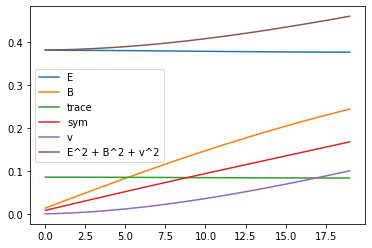

In [221]:
import matplotlib.pyplot as plt

# plot the energy
plt.plot(energyE, label="E")
plt.plot(energyB, label="B")
plt.plot(energytrace, label="trace")
plt.plot(energySym, label="sym")
plt.plot(energyv, label="v")
#plot sum of energy E B v
plt.plot([sqrt(energyE[i]**2 + energyB[i]**2+ energyv[i]**2 ) for i in range(len(energyE))], label="E^2 + B^2 + v^2")
plt.legend()
plt.show()


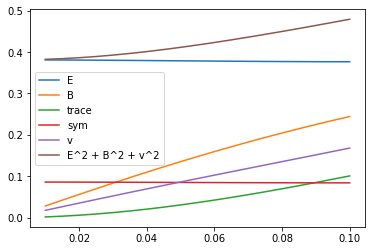

In [219]:
# plot the value of the file energy.txt (the energy of the system) skip the first line
import matplotlib.pyplot as plt
import numpy as np
data = np.loadtxt("energy.txt", delimiter=";", skiprows=1)
plt.plot(data[:,0], data[:,1], label="E")
plt.plot(data[:,0], data[:,2], label="B")
plt.plot(data[:,0], data[:,3], label="trace")
plt.plot(data[:,0], data[:,4], label="sym")
plt.plot(data[:,0], data[:,5], label="v")
# sum 
plt.plot(data[:,0], [sqrt(data[i,1]**2 + data[i,2]**2+ data[i,5]**2 ) for i in range(len(data[:,0]))], label="E^2 + B^2 + v^2")
plt.legend()
# save the plot in a png file with high resolution
plt.savefig("energy.png", dpi=300)


In [220]:
# save the plot in a png file
plt.savefig("energy.png")
plt.show()

<Figure size 432x288 with 0 Axes>